In [8]:
data = [
    (5, 1561), (6, 24189), (7, 177446), (8, 834638), (9, 2867955), 
    (10, 7725801), (11, 16608387), (12, 29270253), (13, 43458000), 
    (14, 56060584), (15, 64085869), (16, 65615931), (17, 59972682), 
    (18, 48703033), (19, 34847821), (20, 21913680), (21, 12070919), 
    (22, 5826221), (23, 2450720), (24, 898929), (25, 284696), (26, 78468), 
    (27, 18417), (28, 3781), (29, 647), (30, 114), (31, 23), (32, 8), 
    (33, 2), (34, 0), (35, 0), (36, 1)
]



In [6]:
polytope_data = [
    {"id": 1, "num_vertices": 3, "vertices": [[-1,2],[2,-1],[-1,-1]]},
    {"id": 2, "num_vertices": 3, "vertices": [[0,1],[1,0],[-1,-1]]},
    {"id": 3, "num_vertices": 3, "vertices": [[0,1],[2,-1],[-2,-1]]},
    {"id": 4, "num_vertices": 3, "vertices": [[0,1],[1,-1],[-1,-1]]},
    {"id": 5, "num_vertices": 4, "vertices": [[-1,1],[1,1],[1,-1],[-1,-1]]},
    {"id": 6, "num_vertices": 4, "vertices": [[0,1],[1,0],[0,-1],[-1,0]]},
    {"id": 7, "num_vertices": 5, "vertices": [[0,1],[1,0],[1,-1],[-1,-1],[-1,1]]},
    {"id": 8, "num_vertices": 5, "vertices": [[0,1],[1,0],[0,-1],[-1,-1],[-1,0]]},
    {"id": 9, "num_vertices": 4, "vertices": [[0,1],[2,-1],[-1,-1],[-1,1]]},
    {"id": 10, "num_vertices": 4, "vertices": [[0,1],[1,0],[0,-1],[-1,-1]]},
    {"id": 11, "num_vertices": 4, "vertices": [[0,1],[2,-1],[-1,-1],[-1,0]]},
    {"id": 12, "num_vertices": 4, "vertices": [[0,1],[1,0],[1,-1],[-1,-1]]},
    {"id": 13, "num_vertices": 3, "vertices": [[0,1],[2,-1],[-1,-1]]},
    {"id": 14, "num_vertices": 4, "vertices": [[0,1],[1,-1],[-1,-1],[-1,1]]},
    {"id": 15, "num_vertices": 5, "vertices": [[0,1],[1,0],[1,-1],[-1,-1],[-1,0]]},
    {"id": 16, "num_vertices": 6, "vertices": [[0,1],[1,0],[1,-1],[0,-1],[-1,0],[1,1]]}
]

data = [
    (3,5), (4,7), (5,3), (6,1)
]

In [20]:
data = [
    (4,48),(5,250),(6,611),(7,964),(8,1051),(9,801),(10,405),(11,143),(12,37),(13,8),(14,1)
    
]

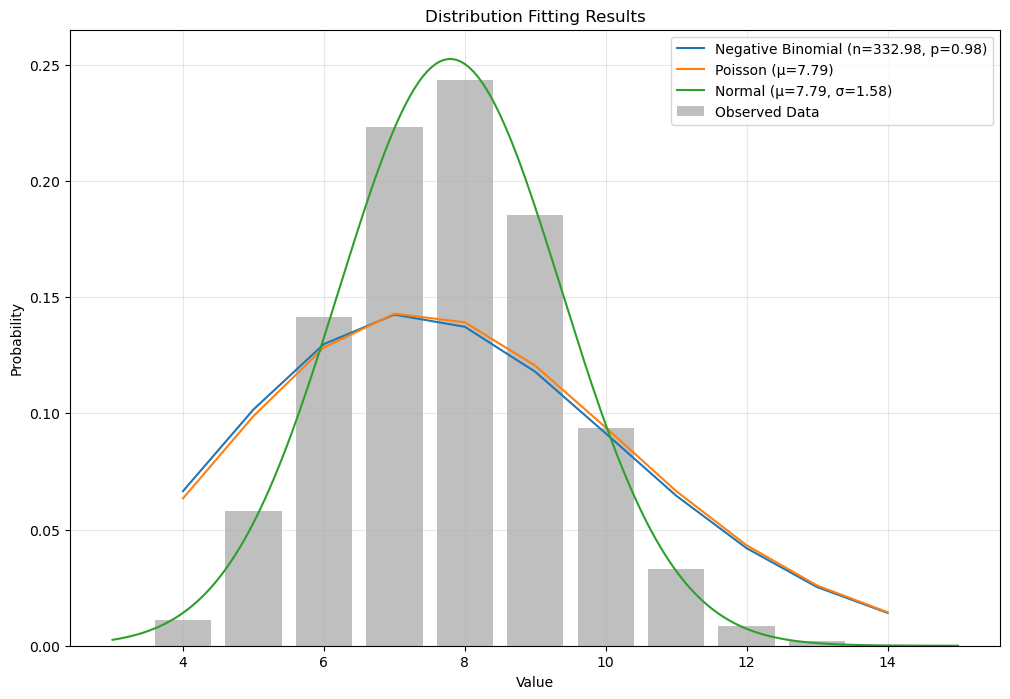


Goodness of Fit Results:

Metric Descriptions:
- Lower values are better for: RMSE, MAE, Chi-square, KL-divergence, Cramer-von Mises, AIC, BIC
- Higher values are better for: R-squared (max 1.0)

Detailed Results:

                   Negative Binomial  Poisson  Normal
chi_square                  0.03060  0.02952 0.00019
rmse                        0.06526  0.06433 0.00540
mae                         0.05601  0.05566 0.00431
r_squared                   0.64212  0.65225 0.99755
kl_divergence               0.17473  0.17102 0.00138
cramer_von_mises            0.00951  0.00923 0.00981
aic                         8.09322  6.08580 7.74652
bic                         8.88901  6.48369 8.54231

Best Fit by Metric:
chi_square: Normal (0.00019)
rmse: Normal (0.00540)
mae: Normal (0.00431)
r_squared: Normal (0.99755)
kl_divergence: Normal (0.00138)
cramer_von_mises: Poisson (0.00923)
aic: Poisson (6.08580)
bic: Poisson (6.48369)


In [21]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from scipy.stats import kstest, anderson

# Convert data to DataFrame


df = pd.DataFrame(data, columns=['x', 'count'])
total_observations = df['count'].sum()
df['weight'] = df['count'] / total_observations

def calculate_goodness_of_fit(observed_data, observed_weights, expected_probs, dist_name, params):
    """Calculate multiple goodness-of-fit metrics"""
    metrics = {}
    
    # Normalize expected probabilities
    expected_probs = expected_probs / expected_probs.sum()
    
    # 1. Chi-Square Statistic
    chi_square = np.sum(observed_weights * ((observed_weights - expected_probs)**2 / expected_probs))
    metrics['chi_square'] = chi_square
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.average((observed_weights - expected_probs)**2, weights=observed_weights))
    metrics['rmse'] = rmse
    
    # 3. Mean Absolute Error (MAE)
    mae = np.average(np.abs(observed_weights - expected_probs), weights=observed_weights)
    metrics['mae'] = mae
    
    # 4. R-squared (coefficient of determination)
    ss_tot = np.sum(observed_weights * (observed_weights - np.mean(observed_weights))**2)
    ss_res = np.sum(observed_weights * (observed_weights - expected_probs)**2)
    r_squared = 1 - (ss_res / ss_tot)
    metrics['r_squared'] = r_squared
    
    # 5. Kullback-Leibler Divergence
    kl_div = np.sum(observed_weights * np.log(observed_weights / expected_probs))
    metrics['kl_divergence'] = kl_div
    
    # 6. Cramer-von Mises Criterion (weighted version)
    n = len(observed_data)
    empirical_cdf = np.cumsum(observed_weights)
    if dist_name == "normal":
        theoretical_cdf = stats.norm.cdf(np.sort(observed_data), *params)
    elif dist_name == "poisson":
        theoretical_cdf = stats.poisson.cdf(np.sort(observed_data), params[0])
    elif dist_name == "negative_binomial":
        theoretical_cdf = stats.nbinom.cdf(np.sort(observed_data), *params)
    
    cvm = np.sum(observed_weights * (empirical_cdf - theoretical_cdf)**2)
    metrics['cramer_von_mises'] = cvm
    
    # 7. Information Criteria
    n_params = len(params)
    log_likelihood = np.sum(observed_weights * np.log(expected_probs))
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(n) * n_params - 2 * log_likelihood
    metrics['aic'] = aic
    metrics['bic'] = bic
    
    return metrics

def fit_distribution(data, weights, dist_name):
    if dist_name == "negative_binomial":
        def neg_bin_loglik(params):
            n, p = params
            return -np.sum(weights * stats.nbinom.logpmf(data, n, p))
        
        result = minimize(neg_bin_loglik, x0=[10, 0.5], bounds=[(0.001, None), (0.001, 0.999)])
        n, p = result.x
        pmf = stats.nbinom.pmf(np.arange(data.min(), data.max()+1), n, p)
        metrics = calculate_goodness_of_fit(data, weights, pmf, dist_name, (n, p))
        return {"name": "Negative Binomial", "params": (n, p), "metrics": metrics}
    
    elif dist_name == "poisson":
        mu = np.average(data, weights=weights)
        pmf = stats.poisson.pmf(np.arange(data.min(), data.max()+1), mu)
        metrics = calculate_goodness_of_fit(data, weights, pmf, dist_name, (mu,))
        return {"name": "Poisson", "params": (mu,), "metrics": metrics}
    
    elif dist_name == "normal":
        mu = np.average(data, weights=weights)
        sigma = np.sqrt(np.average((data - mu)**2, weights=weights))
        x_range = np.linspace(data.min(), data.max(), len(data))
        pdf = stats.norm.pdf(x_range, mu, sigma)
        metrics = calculate_goodness_of_fit(data, weights, pdf, dist_name, (mu, sigma))
        return {"name": "Normal", "params": (mu, sigma), "metrics": metrics}

# Fit distributions and plot
plt.figure(figsize=(12, 8))
plt.bar(df['x'], df['weight'], alpha=0.5, label='Observed Data', color='grey')
x_range = np.linspace(df['x'].min()-1, df['x'].max()+1, 200)

distributions = []
for dist_name in ["negative_binomial", "poisson", "normal"]:
    try:
        fit = fit_distribution(df['x'].values, df['weight'].values, dist_name)
        distributions.append(fit)
        
        if fit["name"] == "Normal":
            mu, sigma = fit["params"]
            y = stats.norm.pdf(x_range, mu, sigma)
            plt.plot(x_range, y, label=f'Normal (μ={mu:.2f}, σ={sigma:.2f})')
        elif fit["name"] == "Poisson":
            mu = fit["params"][0]
            y = stats.poisson.pmf(np.arange(df['x'].min(), df['x'].max()+1), mu)
            plt.plot(np.arange(df['x'].min(), df['x'].max()+1), y, label=f'Poisson (μ={mu:.2f})')
        elif fit["name"] == "Negative Binomial":
            n, p = fit["params"]
            y = stats.nbinom.pmf(np.arange(df['x'].min(), df['x'].max()+1), n, p)
            plt.plot(np.arange(df['x'].min(), df['x'].max()+1), y, label=f'Negative Binomial (n={n:.2f}, p={p:.2f})')
    except Exception as e:
        print(f"Failed to fit {dist_name}: {str(e)}")

plt.title('Distribution Fitting Results')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print comprehensive goodness-of-fit results
print("\nGoodness of Fit Results:")
print("\nMetric Descriptions:")
print("- Lower values are better for: RMSE, MAE, Chi-square, KL-divergence, Cramer-von Mises, AIC, BIC")
print("- Higher values are better for: R-squared (max 1.0)")
print("\nDetailed Results:")

metrics_df = pd.DataFrame()
for dist in distributions:
    metrics_df[dist['name']] = pd.Series(dist['metrics'])

# Format the metrics dataframe for better display
pd.set_option('display.float_format', lambda x: '%.5f' % x)
print("\n", metrics_df.round(5))

# Find best fit according to each metric
print("\nBest Fit by Metric:")
for metric in metrics_df.index:
    if metric in ['r_squared']:
        best_dist = metrics_df.loc[metric].idxmax()
        best_value = metrics_df.loc[metric].max()
    else:
        best_dist = metrics_df.loc[metric].idxmin()
        best_value = metrics_df.loc[metric].min()
    print(f"{metric}: {best_dist} ({best_value:.5f})")

In [ ]:
normal 4, .87
normal 7.79 1.58
normal 15.77, 2.78

In [19]:
import os
import urllib.request
file_path = "/home/ahatziiliou/Math/polys/"
file_url = "http://hep.itp.tuwien.ac.at/~kreuzer/pub/K3/RefPoly.d3"

# Download the file
urllib.request.urlretrieve(file_url, file_path)
print("Download completed.")


IsADirectoryError: [Errno 21] Is a directory: '/home/ahatziiliou/Math/polys/'

Analysis of Growth Patterns:

Mean growth rates between dimensions:
  2 to 3: 1.95x
  3 to 4: 2.02x

Std Dev growth rates between dimensions:
  2 to 3: 1.82x
  3 to 4: 1.76x

Predicted values for higher dimensions:

Dimension 5:
  Predicted Mean: 16.00
  Predicted Std Dev: 5.07
  Upper Bound: 88.18

Dimension 6:
  Predicted Mean: 32.00
  Predicted Std Dev: 9.13
  Upper Bound: 216.00

Dimension 7:
  Predicted Mean: 64.00
  Predicted Std Dev: 16.44
  Upper Bound: 529.09

Dimension 8:
  Predicted Mean: 128.00
  Predicted Std Dev: 29.59
  Upper Bound: 1296.00

Dimension 9:
  Predicted Mean: 256.00
  Predicted Std Dev: 53.26
  Upper Bound: 3174.54


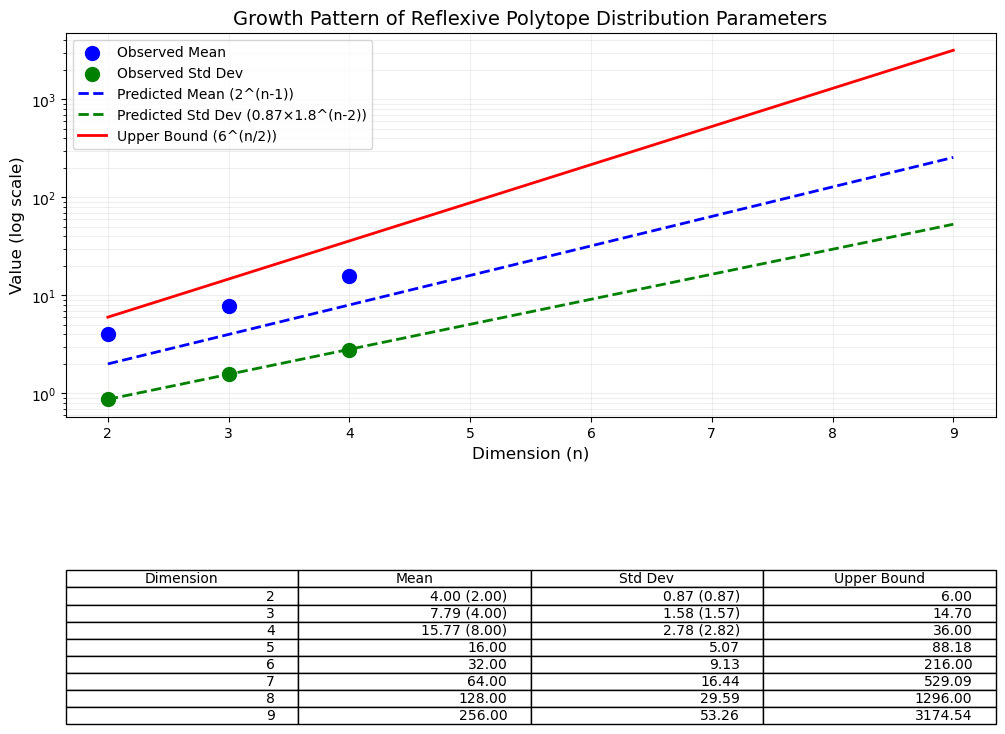

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Observed data
dimensions_observed = [2, 3, 4]
means_observed = [4.00, 7.79, 15.77]
sigmas_observed = [0.87, 1.58, 2.78]

# Generate predictions for dimensions 2-9
dimensions = np.arange(2, 10)
means_predicted = 2**(dimensions-1)
sigmas_predicted = 0.87 * 1.8**(dimensions-2)
upper_bounds = 6**(dimensions/2)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot observed data points
plt.scatter(dimensions_observed, means_observed, color='blue', s=100, label='Observed Mean', zorder=5)
plt.scatter(dimensions_observed, sigmas_observed, color='green', s=100, label='Observed Std Dev', zorder=5)

# Plot predicted curves
plt.plot(dimensions, means_predicted, 'b--', label='Predicted Mean (2^(n-1))', linewidth=2)
plt.plot(dimensions, sigmas_predicted, 'g--', label='Predicted Std Dev (0.87×1.8^(n-2))', linewidth=2)
plt.plot(dimensions, upper_bounds, 'r-', label='Upper Bound (6^(n/2))', linewidth=2)

# Customize the plot
plt.yscale('log')  # Use log scale for y-axis to better show growth
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Dimension (n)', fontsize=12)
plt.ylabel('Value (log scale)', fontsize=12)
plt.title('Growth Pattern of Reflexive Polytope Distribution Parameters', fontsize=14)
plt.legend(loc='upper left', fontsize=10)

# Add table with numerical values
table_data = []
headers = ['Dimension', 'Mean', 'Std Dev', 'Upper Bound']
for i, dim in enumerate(dimensions):
    mean = means_predicted[i]
    sigma = sigmas_predicted[i]
    bound = upper_bounds[i]
    if dim <= 4:
        mean_str = f"{means_observed[int(dim)-2]:.2f} ({mean:.2f})"
        sigma_str = f"{sigmas_observed[int(dim)-2]:.2f} ({sigma:.2f})"
    else:
        mean_str = f"{mean:.2f}"
        sigma_str = f"{sigma:.2f}"
    table_data.append([dim, mean_str, sigma_str, f"{bound:.2f}"])

plt.table(cellText=table_data,
         colLabels=headers,
         loc='bottom',
         bbox=[0, -0.8, 1, 0.4])  # Adjust the table position

# Adjust layout to make room for the table
plt.subplots_adjust(bottom=0.4)

# Print analysis
print("Analysis of Growth Patterns:")
print("\nMean growth rates between dimensions:")
for i in range(len(dimensions_observed)-1):
    growth = means_observed[i+1] / means_observed[i]
    print(f"  {dimensions_observed[i]} to {dimensions_observed[i+1]}: {growth:.2f}x")

print("\nStd Dev growth rates between dimensions:")
for i in range(len(dimensions_observed)-1):
    growth = sigmas_observed[i+1] / sigmas_observed[i]
    print(f"  {dimensions_observed[i]} to {dimensions_observed[i+1]}: {growth:.2f}x")

print("\nPredicted values for higher dimensions:")
for dim in range(5, 10):
    mean = 2**(dim-1)
    sigma = 0.87 * 1.8**(dim-2)
    bound = 6**(dim/2)
    print(f"\nDimension {dim}:")
    print(f"  Predicted Mean: {mean:.2f}")
    print(f"  Predicted Std Dev: {sigma:.2f}")
    print(f"  Upper Bound: {bound:.2f}")import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate

def probability_outside_bounds(mu, sigma, lower, upper):
    """Calculate probability of values outside the bounds"""
    return 1 - (norm.cdf(upper, mu, sigma) - norm.cdf(lower, mu, sigma))

def adjust_parameters(dim, initial_mu, initial_sigma):
    """Adjust μ and σ to ensure negligible probability outside bounds"""
    lower = dim
    upper = 6**(dim/2)
    
    # We want probability outside bounds to be < 0.001
    target_prob = 0.001
    
    # If probability outside bounds is too high, adjust sigma
    prob_outside = probability_outside_bounds(initial_mu, initial_sigma, lower, upper)
    
    if prob_outside > target_prob:
        # Binary search for appropriate sigma
        low_sigma = 0.1
        high_sigma = initial_sigma
        
        while high_sigma - low_sigma > 0.01:
            mid_sigma = (low_sigma + high_sigma) / 2
            prob = probability_outside_bounds(initial_mu, mid_sigma, lower, upper)
            
            if prob > target_prob:
                high_sigma = mid_sigma
            else:
                low_sigma = mid_sigma
        
        return initial_mu, low_sigma
    
    return initial_mu, initial_sigma

# Original observed data
dimensions_observed = [2, 3, 4]
means_observed = [4.00, 7.79, 15.77]
sigmas_observed = [0.87, 1.58, 2.78]

# Generate and adjust predictions for dimensions 2-9
dimensions = np.arange(2, 10)
means_predicted = []
sigmas_predicted = []
upper_bounds = 6**(dimensions/2)
lower_bounds = dimensions

for dim in dimensions:
    # Initial predictions using original formulas
    initial_mu = 2**(dim-1)
    initial_sigma = 0.87 * 1.8**(dim-2)
    
    # Adjust parameters to respect bounds
    mu, sigma = adjust_parameters(dim, initial_mu, initial_sigma)
    means_predicted.append(mu)
    sigmas_predicted.append(sigma)

means_predicted = np.array(means_predicted)
sigmas_predicted = np.array(sigmas_predicted)

# Plotting
plt.figure(figsize=(15, 10))

# Create two subplots
plt.subplot(2, 1, 1)

# Plot bounds and predictions
plt.plot(dimensions, upper_bounds, 'r-', label='Upper Bound (6^(n/2))', linewidth=2)
plt.plot(dimensions, lower_bounds, 'r-', label='Lower Bound (n)', linewidth=2)
plt.plot(dimensions, means_predicted, 'b--', label='Predicted Mean', linewidth=2)

# Plot observed points
plt.scatter(dimensions_observed, means_observed, color='blue', s=100, label='Observed Mean', zorder=5)

# Add error bars for ±2σ
for i, dim in enumerate(dimensions_observed):
    plt.errorbar(dim, means_observed[i], yerr=2*sigmas_observed[i], 
                color='blue', capsize=5, capthick=2, zorder=4)

plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.ylabel('Value (log scale)', fontsize=12)
plt.title('Distribution Parameters with Bounded Integer Constraints', fontsize=14)
plt.legend()

# Second subplot for probability densities
plt.subplot(2, 1, 2)

# Plot probability density functions for each dimension
x = np.linspace(1, max(upper_bounds), 1000)
for i, dim in enumerate(dimensions[:5]):  # Only plot first 5 dimensions for clarity
    lower = dim
    upper = 6**(dim/2)
    mu = means_predicted[i]
    sigma = sigmas_predicted[i]
    
    # Normalize PDF to account for integer constraint
    pdf = norm.pdf(x, mu, sigma)
    pdf = pdf / sum(norm.pdf(np.arange(int(lower), int(upper)+1), mu, sigma))
    
    plt.plot(x, pdf, label=f'n={dim}', alpha=0.7)

plt.xlabel('Value', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.grid(True, alpha=0.2)
plt.legend(title='Dimension')

plt.tight_layout()

# Print analysis
print("\nAdjusted Distribution Parameters:")
print("Dim\tMean\tSigma\tLower\tUpper\tP(outside)")
for i, dim in enumerate(dimensions):
    lower = dim
    upper = 6**(dim/2)
    mu = means_predicted[i]
    sigma = sigmas_predicted[i]
    p_outside = probability_outside_bounds(mu, sigma, lower, upper)
    print(f"{dim}\t{mu:.2f}\t{sigma:.2f}\t{lower:.2f}\t{upper:.2f}\t{p_outside:.6f}")


Adjusted Distribution Parameters:
Dim	Mean	Sigma	Lower	Upper	P(outside)
2	2.00	0.10	2.00	6.00	0.500000
3	4.00	0.32	3.00	14.70	0.000992
4	8.00	1.29	4.00	36.00	0.000961
5	16.00	3.56	5.00	88.18	0.000996
6	32.00	8.41	6.00	216.00	0.000995
7	64.00	16.44	7.00	529.09	0.000263
8	128.00	29.59	8.00	1296.00	0.000025
9	256.00	53.26	9.00	3174.54	0.000002


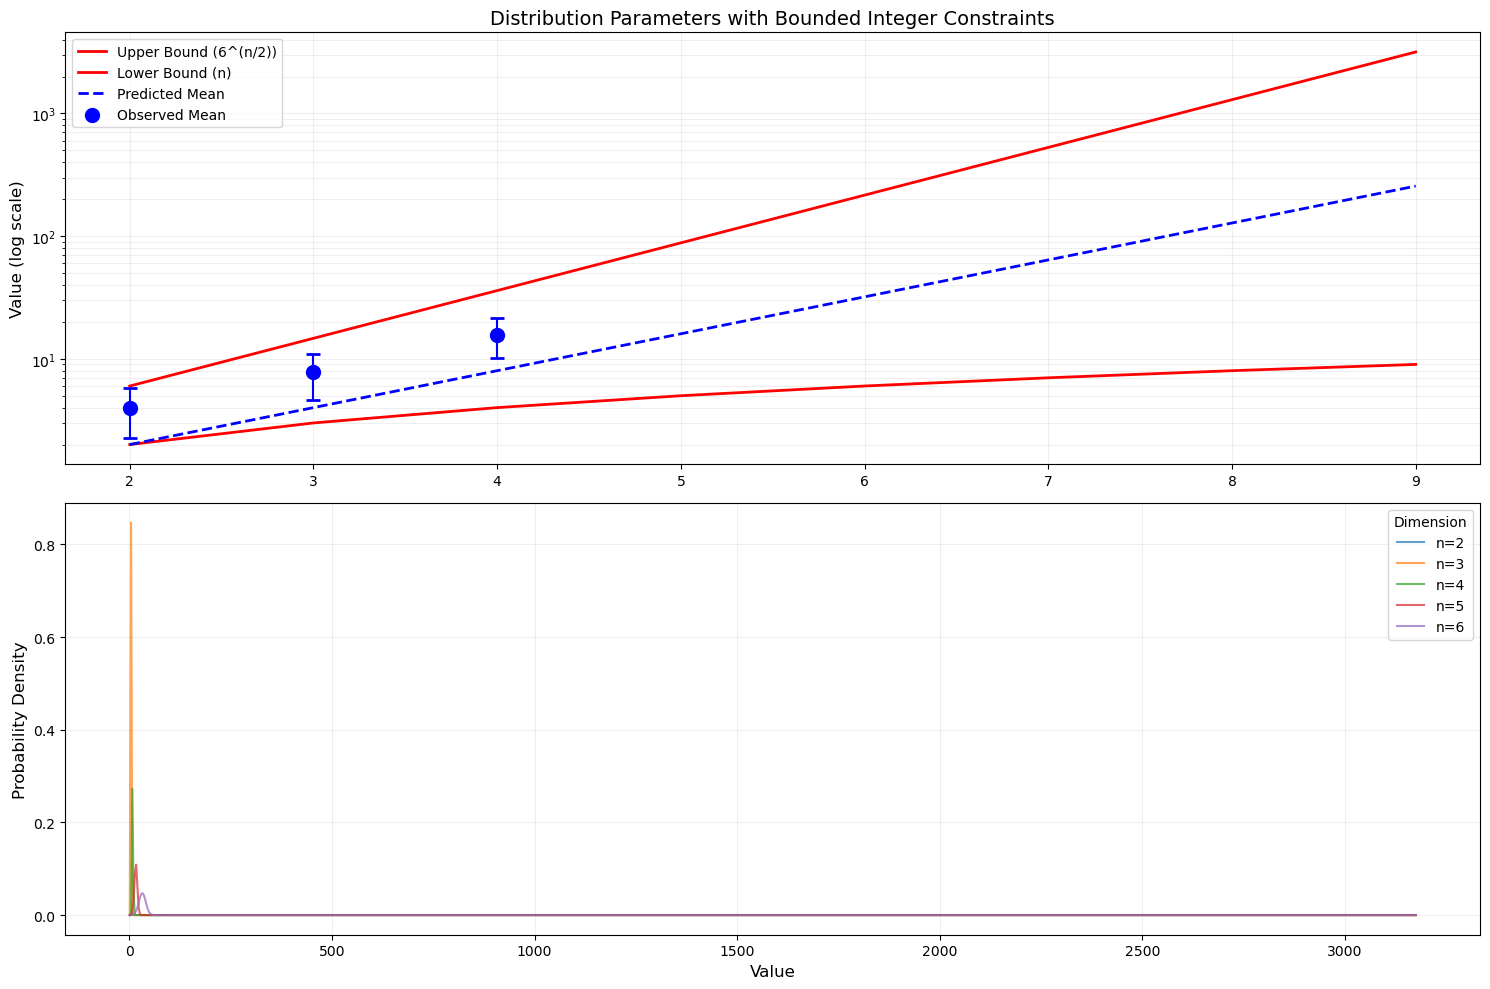

In [23]:
import numpy as np
from scipy.stats import norm

# Observed data
dims = [2, 3, 4]
mus = [4.00, 7.79, 15.77]
sigmas = [0.87, 1.58, 2.78]

# Calculate growth ratios
mu_ratios = [mus[i+1]/mus[i] for i in range(len(mus)-1)]
sigma_ratios = [sigmas[i+1]/sigmas[i] for i in range(len(sigmas)-1)]

print("Growth Analysis:")
print(f"Mean growth ratios: {[f'{r:.2f}' for r in mu_ratios]}")
print(f"Sigma growth ratios: {[f'{r:.2f}' for r in sigma_ratios]}")

# Function to check if parameters are reasonable given bounds
def validate_parameters(n, mu, sigma):
    lower = n
    upper = 6**(n/2)
    # Calculate probability outside bounds
    p_outside = 1 - (norm.cdf(upper, mu, sigma) - norm.cdf(lower, mu, sigma))
    return p_outside < 0.001

# Make predictions for dimensions 5-8
predictions = []
for n in range(5, 9):
    # Calculate bounds
    lower = n
    upper = 6**(n/2)
    
    # Predict parameters based on observed growth
    predicted_mu = mus[-1] * (mu_ratios[-1])**(n-4)
    predicted_sigma = sigmas[-1] * (sigma_ratios[-1])**(n-4)
    
    # Validate and adjust if necessary
    while not validate_parameters(n, predicted_mu, predicted_sigma):
        predicted_sigma *= 0.95  # Reduce sigma if probability mass outside bounds is too high
    
    predictions.append({
        'dimension': n,
        'mu': predicted_mu,
        'sigma': predicted_sigma,
        'lower_bound': lower,
        'upper_bound': upper
    })

# Print results
print("\nPredicted Parameters:")
print("Dim\tμ\tσ\tBounds")
print("-" * 40)
for p in predictions:
    print(f"{p['dimension']}\t{p['mu']:.2f}\t{p['sigma']:.2f}\t({p['lower_bound']}, {p['upper_bound']:.1f})")

In [1]:
import numpy as np
from scipy.stats import norm

# Observed data
dims = [2, 3, 4]
mus = [4.00, 7.79, 15.77]
sigmas = [0.87, 1.58, 2.78]

# Calculate growth ratios
mu_ratios = [mus[i+1]/mus[i] for i in range(len(mus)-1)]
sigma_ratios = [sigmas[i+1]/sigmas[i] for i in range(len(sigmas)-1)]

print("Growth Analysis:")
print(f"Mean growth ratios: {[f'{r:.2f}' for r in mu_ratios]}")
print(f"Sigma growth ratios: {[f'{r:.2f}' for r in sigma_ratios]}")

# Function to check if parameters are reasonable given bounds
def validate_parameters(n, mu, sigma):
    lower = n
    upper = 6**(n/2)
    # Calculate probability outside bounds
    p_outside = 1 - (norm.cdf(upper, mu, sigma) - norm.cdf(lower, mu, sigma))
    return p_outside < 0.001

# Make predictions for dimensions 5-8
predictions = []
for n in range(5, 9):
    # Calculate bounds
    lower = n
    upper = 6**(n/2)
    
    # Predict parameters based on observed growth
    predicted_mu = mus[-1] * (mu_ratios[-1])**(n-4)
    predicted_sigma = sigmas[-1] * (sigma_ratios[-1])**(n-4)
    
    # Validate and adjust if necessary
    while not validate_parameters(n, predicted_mu, predicted_sigma):
        predicted_sigma *= 0.95  # Reduce sigma if probability mass outside bounds is too high
    
    predictions.append({
        'dimension': n,
        'mu': predicted_mu,
        'sigma': predicted_sigma,
        'lower_bound': lower,
        'upper_bound': upper
    })

# Print results
print("\nPredicted Parameters:")
print("Dim\tμ\tσ\tBounds")
print("-" * 40)
for p in predictions:
    print(f"{p['dimension']}\t{p['mu']:.2f}\t{p['sigma']:.2f}\t({p['lower_bound']}, {p['upper_bound']:.1f})")

Growth Analysis:
Mean growth ratios: ['1.95', '2.02']
Sigma growth ratios: ['1.82', '1.76']

Predicted Parameters:
Dim	μ	σ	Bounds
----------------------------------------
5	31.92	4.89	(5, 88.2)
6	64.63	8.61	(6, 216.0)
7	130.83	15.14	(7, 529.1)
8	264.86	26.64	(8, 1296.0)
